In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models 

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

num_epochs = 5
batch_size = 40
learning_rate = 0.001

classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

cuda


In [47]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )
])

train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = transform)

test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [48]:
train_loader = torch.utils.data.DataLoader(train_dataset
    , batch_size = batch_size
    , shuffle = True)

test_loader = torch.utils.data.DataLoader(test_dataset
    , batch_size = batch_size
    , shuffle = True)

n_total_step = len(train_loader)
print(n_total_step)

1250


In [50]:
model = models.vgg16(pretrained = True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/eddy/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [55]:
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        labels_hat = model(imgs)
        n_corrects = (labels_hat.argmax(axis=1)==labels).sum().item()
        loss_value = criterion(labels_hat, labels)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i+1) % 250 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step: {i+1}/{n_total_step}: loss = {loss_value:.5f}, acc = {100*(n_corrects/labels.size(0)):.2f}%')
    print()

epoch 1/5, step: 250/1250: loss = 0.44248, acc = 85.00%
epoch 1/5, step: 500/1250: loss = 0.27348, acc = 92.50%
epoch 1/5, step: 750/1250: loss = 0.38312, acc = 92.50%
epoch 1/5, step: 1000/1250: loss = 0.21015, acc = 90.00%
epoch 1/5, step: 1250/1250: loss = 0.23243, acc = 87.50%

epoch 2/5, step: 250/1250: loss = 0.20257, acc = 92.50%
epoch 2/5, step: 500/1250: loss = 0.33113, acc = 82.50%
epoch 2/5, step: 750/1250: loss = 0.21629, acc = 92.50%
epoch 2/5, step: 1000/1250: loss = 0.19868, acc = 90.00%
epoch 2/5, step: 1250/1250: loss = 0.14304, acc = 92.50%

epoch 3/5, step: 250/1250: loss = 0.04632, acc = 97.50%
epoch 3/5, step: 500/1250: loss = 0.13874, acc = 92.50%
epoch 3/5, step: 750/1250: loss = 0.15035, acc = 95.00%
epoch 3/5, step: 1000/1250: loss = 0.04548, acc = 100.00%
epoch 3/5, step: 1250/1250: loss = 0.05876, acc = 97.50%

epoch 4/5, step: 250/1250: loss = 0.01285, acc = 100.00%
epoch 4/5, step: 500/1250: loss = 0.16117, acc = 92.50%
epoch 4/5, step: 750/1250: loss = 0.1

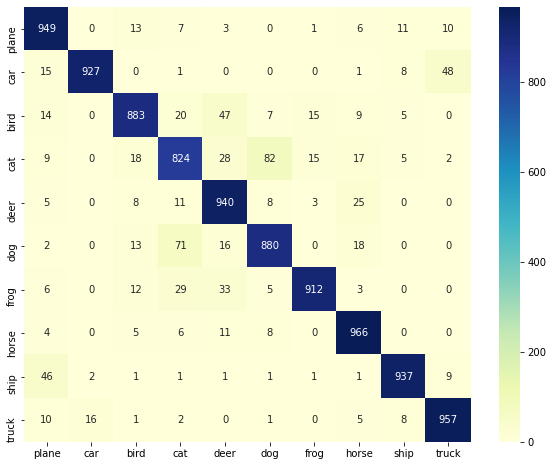

In [58]:
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label,predicted_label] += 1
            
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

In [59]:
torch.save(model, 'models/vgg16_CIFAR10_basic')